In [1]:
using Pkg
Pkg.activate(pwd())
Pkg.instantiate()
Pkg.develop("QuantumDots")
Pkg.add("DifferentialEquations")
using QuantumDots, QuantumDots.BlockDiagonals, LinearAlgebra
using Plots
using DifferentialEquations

  Activating project at `c:\Users\svens\.julia\dev\QuantumDots\examples`

   Resolving package versions...


  No Changes to `C:\Users\svens\.julia\dev\QuantumDots\examples\Project.toml`
  No Changes to `C:\Users\svens\.julia\dev\QuantumDots\examples\Manifest.toml`


   Resolving package versions...


  No Changes to `C:\Users\svens\.julia\dev\QuantumDots\examples\Project.toml`
  No Changes to `C:\Users\svens\.julia\dev\QuantumDots\examples\Manifest.toml`


In [2]:
struct MajoranaWrapper{B,D}
    basis::B
    majoranas::D
    function MajoranaWrapper(basis, labels=collect(Base.product(keys(basis), (:a, :b))))
        N = length(basis)
        length(labels) == 2 * N || throw(ErrorException("Number of majoranas is not twice the fermion number"))
        majA = map(f -> f + f', basis)
        majB = map(f -> 1im * (f - f'), basis)
        majs = vcat(majA, majB)
        dA = QuantumDots.dictionary(zip(labels[1:N], values(majA)))
        dB = QuantumDots.dictionary(zip(labels[N+1:2N], values(majB)))
        d = merge(dA, dB)
        new{typeof(basis),typeof(d)}(basis, d)
    end
end
Base.getindex(g::MajoranaWrapper, i...) = g.majoranas[i...]

In [3]:
c = FermionBasis(1:2)
γ = MajoranaWrapper(c, 0:3)

MajoranaWrapper{FermionBasis{2, Int64, SparseArrays.SparseMatrixCSC{Int64, Int64}, QuantumDots.NoSymmetry}, Dictionaries.Dictionary{Int64, SparseArrays.SparseMatrixCSC{T, Int64} where T}}(FermionBasis{2,Int64,SparseArrays.SparseMatrixCSC{Int64, Int64},QuantumDots.NoSymmetry}:
keys = {1, 2}, {0 = sparse([2, 1, 4, 3], [1, 2, 3, 4], [1, 1, -1, -1], 4, 4), 1 = sparse([3, 4, 1, 2], [1, 2, 3, 4], [1, 1, 1, 1], 4, 4), 2 = sparse([2, 1, 4, 3], [1, 2, 3, 4], Complex{Int64}[0 - 1im, 0 + 1im, 0 + 1im, 0 - 1im], 4, 4), 3 = sparse([3, 4, 1, 2], [1, 2, 3, 4], Complex{Int64}[0 - 1im, 0 - 1im, 0 + 1im, 0 + 1im], 4, 4)})

In [4]:
smooth_step(x, k) = 1 / 2 + tanh(k * x) / 2
# Give the value of the three deltas at time t in the three point majorana braiding protocol
function braiding_deltas(t, T, Δmax, Δmin, k, args...)
    Δ1 = Δtrajectory(t, T, Δmax, Δmin, k)
    Δ2 = Δtrajectory(t + T / 3, T, Δmax, Δmin, k)
    Δ3 = Δtrajectory(t + 2T / 3, T, Δmax, Δmin, k)
    return Δ1, Δ2, Δ3
end
function Δtrajectory(t, T, Δmax, Δmin, k, args...)
    dΔ = Δmax - Δmin
    tp = mod(t, T) - T / 12
    Δmin + dΔ * smooth_step(tp - 1T / 6, k) - dΔ * smooth_step(tp - 4T / 6, k)
end

Δtrajectory (generic function with 1 method)

(101, 3)

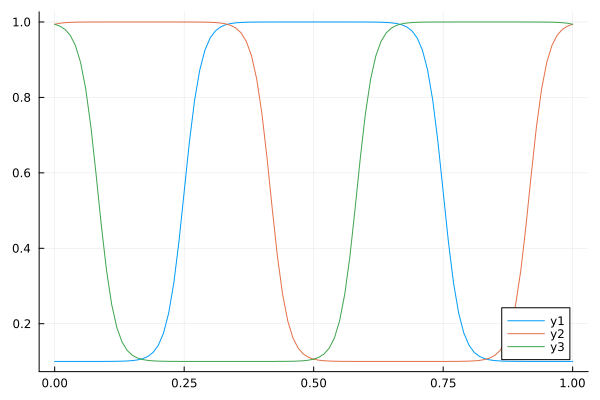

In [5]:
let T = 1, Δmax = 1, Δmin = 0.1, k = 30
    ts =  0:0.01:T
    deltas = stack([braiding_deltas(t, T, Δmax, Δmin, k) for t in ts])'
    println(size(deltas))
    plot(ts,deltas)
end

In [35]:
const γ01 = Matrix(1.0im * γ[0] * γ[1])
const γ02 = Matrix(1.0im * γ[0] * γ[2])
const γ03 = Matrix(1.0im * γ[0] * γ[3])

4×4 Matrix{ComplexF64}:
  0.0+0.0im   0.0+0.0im   0.0+0.0im  -1.0+0.0im
  0.0+0.0im   0.0+0.0im  -1.0+0.0im   0.0+0.0im
  0.0+0.0im  -1.0+0.0im   0.0+0.0im   0.0+0.0im
 -1.0+0.0im   0.0+0.0im   0.0+0.0im   0.0+0.0im

In [36]:
# H(t, (T, Δmin, Δmax, k, σ)) = H(t, (T, Δmin, Δmax, k))
function H(t, (T, Δmin, Δmax, k))
    Δ1, Δ2, Δ3 = braiding_deltas(t, T, Δmax, Δmin, k)
    Δ1 * γ01 + Δ2 * γ02 + Δ3 * γ03
end
function H(t, (T, Δmin, Δmax, k), W)
    Δ1, Δ2, Δ3 = braiding_deltas(t, T, Δmax, Δmin, k)
    # if rand()<.001
    #     println("____")
    #     println(t)
    #     println(W)
    # end
    (W[1]  + Δ1) * γ01 + (W[2]  + Δ2) * γ02 + (W[3] + Δ3) * γ03
    #Δ1 * γ01 + Δ2 * γ02 + Δ3 * γ03
end

H (generic function with 2 methods)

In [37]:
function g(du, uv, (T, Δmin, Δmax, k), t)
    u = reshape(uv, size(γ01))
    du[:, 1] .= 1im .* vec(γ01 * u - u * γ01)
    du[:, 2] .= 1im .* vec(γ02 * u - u * γ02)
    du[:, 3] .= 1im .* vec(γ03 * u - u * γ03)
end

g (generic function with 1 method)

In [38]:
_du = zeros(ComplexF64, length(γ01),3)
g(_du, rand(ComplexF64,4,4), (1, 0.1, 10, 50,1.0im), .2);
[tr(reshape(_du[:,n],4,4)) for n in 1:3]

3-element Vector{ComplexF64}:
 0.0 + 1.1102230246251565e-16im
 0.0 + 0.0im
 0.0 + 0.0im

In [39]:
function schrödinger!(du, u, p, t)
    ham = H(t, p)
    mul!(du, ham, u, 1im, 0)
    return du
end
function braid_heisenberg!(du, u, p, t)
    ham = H(t, p)
    heisenberg!(du, u, p, t, ham)
end
function braid_heisenberg!(du, u, p, t, W)
    ham = H(t, p, W)
    heisenberg!(du, u, p, t, ham)
end
function heisenberg!(du, u, p, t, ham)
    mul!(du, ham, u, 1im, 0)
    mul!(du, u, ham, -1im, 1)
    # du .= 1im .* (ham * u .- u * ham)
    return du
end
function braid_heisenbergvec!(duv, uv, p, t)
    u = reshape(uv, size(γ01))
    du = reshape(duv, size(γ01))
    ham = H(t, p)
    # heisenberg!(du, u, p, t)
    duv .= 1im .* vec(ham * u .- u * ham)
    return duv
end

braid_heisenbergvec! (generic function with 1 method)

In [83]:
u0 = 1.0complex(Matrix(γ[1]))
T = 0.1
k = 100 / T
Δmax = 1e2 / T
Δmin = Δmax * 1e-2
σ = Δmax/10
p = (T, Δmin, Δmax, k)
tspan = (0.0, 2T)
prob = ODEProblem(braid_heisenberg!, u0, tspan, p)
# W = RealWienerProcess(0.0, zeros(3), zeros(3))
W = OrnsteinUhlenbeckProcess(1/(T), 0.0, σ, 0.0, zeros(3), zeros(3))
sdeprob = SDEProblem(braid_heisenbergvec!, g, deepcopy(vec(u0)), tspan, p,
    noise_rate_prototype=zeros(ComplexF64, length(γ01), 3),
    noise=W)
rodeprob = RODEProblem(braid_heisenberg!, u0, tspan, p, noise=W, rand_prototype=zeros(Float64, 3))

# sdeprob = SDEProblem(foo,foog, deepcopy(vec(u0)), tspan, p,
#noise_rate_prototype=zeros(ComplexF64, length(γ01), 1),
#noise=RealWienerProcess(0.0, [0.0], [0.0]))

# sdeprob = ODEProblem(heisenbergvec!, deepcopy(vec(u0)), tspan, p,)
ts = range(0, tspan[2], 300)
deltas = stack([braiding_deltas(t, p...) for t in ts])'
plot(ts, deltas);

In [84]:
@time sol = solve(prob, saveat=ts)
# @time sdesol = solve(sdeprob, RKMilCommute(), saveat = ts)
#@time sdesol = solve(sdeprob,ISSEM(autodiff=false), #ImplicitEulerHeun(symplectic=true, theta=1 / 2, autodiff=false),
#    saveat=ts, abstol=1e-3, reltol=1e-8, adaptive=false, dt = T/1000)
#@time sdesol2 = solve(sdeprob, SImplicitMidpoint(symplectic=true, theta=1 / 2, autodiff=false),
#    saveat=ts, abstol=1e-3, reltol=1e-8)
@time rodesol = solve(rodeprob, saveat=ts, dt = T/100000, abstol=1e-3, reltol=1e-8)
# @time sdesol = solve(sdeprob; saveat=ts)#, ImplicitEM(autodiff=false), saveat = ts)

  0.006285 seconds (23.02 k allocations: 7.376 MiB)


  0.640341 seconds (4.00 M allocations: 514.057 MiB, 23.43% gc time)


retcode: Success
Interpolation: 1st order linear
t: 300-element Vector{Float64}:
 0.0
 0.0006688963210702341
 0.0013377926421404682
 0.002006688963210702
 0.0026755852842809363
 0.0033444816053511705
 0.004013377926421404
 0.0046822742474916385
 0.005351170568561873
 0.006020066889632107
 ⋮
 0.19464882943143813
 0.19531772575250836
 0.1959866220735786
 0.19665551839464884
 0.19732441471571907
 0.1979933110367893
 0.19866220735785953
 0.19933110367892976
 0.2
u: 300-element Vector{Matrix{ComplexF64}}:
 [0.0 + 0.0im 0.0 + 0.0im 1.0 + 0.0im 0.0 + 0.0im; 0.0 + 0.0im 0.0 + 0.0im 0.0 + 0.0im 1.0 + 0.0im; 1.0 + 0.0im 0.0 + 0.0im 0.0 + 0.0im 0.0 + 0.0im; 0.0 + 0.0im 1.0 + 0.0im 0.0 + 0.0im 0.0 + 0.0im]
 [0.0 + 0.0im -0.006699794573789203 - 0.006550680815407109im 0.9999348377097222 - 0.006541054044067887im 0.0 + 0.0im; -0.006699794573789202 + 0.006550680815407107im 0.0 + 0.0im 0.0 + 0.0im 0.9999348377097222 - 0.006541054044067885im; 0.9999348377097222 + 0.006541054044067883im 0.0 + 0.0im 0.0 + 

In [85]:
projs = stack([[abs(tr(γ * sol(t))) for γ in (γ[1], γ[2], γ[3])] for t in ts])';
#sdeprojs = stack([[abs(tr(γ * reshape(sdesol(t), size(γ)))) for γ in (γ[1], γ[2], γ[3])] for t in ts])';
#sdeprojs2 = stack([[abs(tr(γ * reshape(sdesol2(t), size(γ)))) for γ in (γ[1], γ[2], γ[3])] for t in ts])';
rodeprojs = stack([[abs(tr(γ * rodesol(t))) for γ in (γ[1], γ[2], γ[3])] for t in ts])';

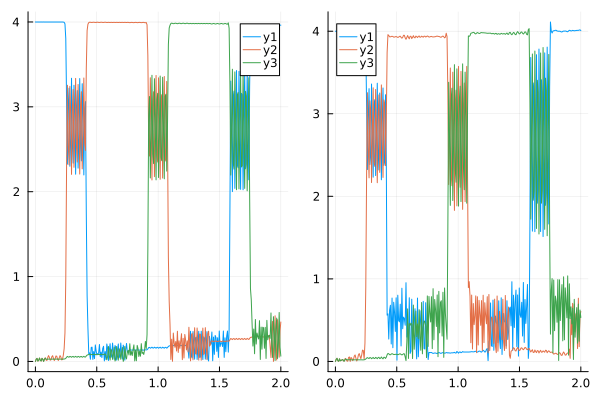

In [86]:
plot(plot(ts ./ T, projs), plot(ts ./ T, rodeprojs))#, plot(ts ./ T, sdeprojs))#, plot(ts ./ T, sdeprojs2))

In [87]:
plot(ts ./ T, sdeprojs)

UndefVarError: UndefVarError: `sdeprojs` not defined

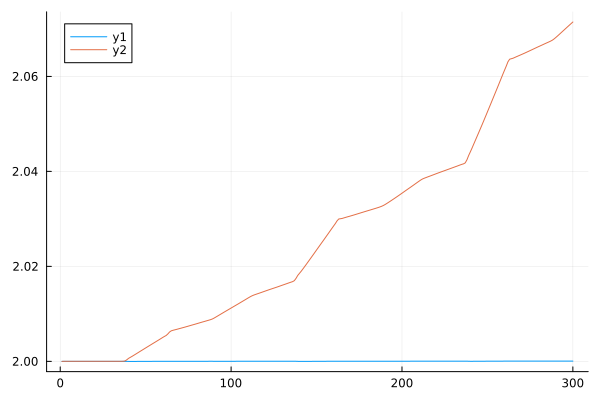

In [88]:
plot(map(norm, sol))
#plot!(map(norm, sdesol))
# plot!(map(norm, sdesol2))
plot!(map(norm, rodesol))

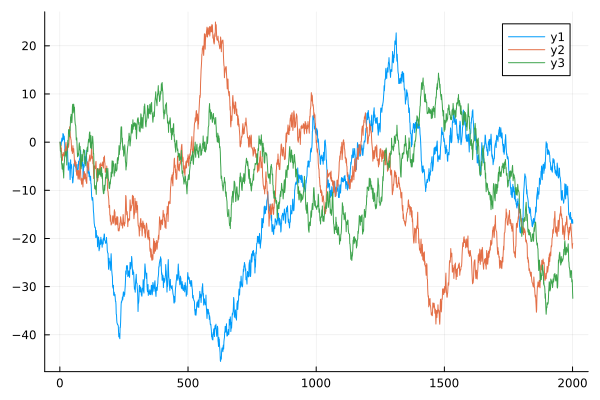

In [89]:
plot(stack(rodesol.W.u)'[1:100:end,:])

In [201]:
plot(ts,stack(first.(sdesol.noise.(ts)))')

MethodError: MethodError: objects of type Nothing are not callable

In [97]:
function prob_func(prob, i, repeat)
    #W = RealWienerProcess(0.0, zeros(3), zeros(3))
    W = OrnsteinUhlenbeckProcess(1/(T), 0.0, Δmax/5, 0.0, zeros(3), zeros(3))
    remake(prob; noise=W)
end
ensembleprob = EnsembleProblem(rodeprob;
    prob_func,
    #output_func=(sol, i) -> (map(s -> push!([abs(tr(γ * reshape(s, size(γ)))) for γ in (γ[1], γ[2], γ[3])], norm(s)), sol), false))
    output_func=(sol, i) -> ((map(s -> push!([abs(tr(γ * (s))) for γ in (γ[1], γ[2], γ[3])], norm(s)), sol)), false))

EnsembleProblem with problem RODEProblem

In [98]:
enssol = solve(ensembleprob, EnsembleThreads(), #ImplicitEulerHeun(symplectic=true, theta=1 / 2, autodiff=false),
    trajectories=10, saveat=ts, abstol=1e-6, reltol=1e-8, dt = T/100000)

EnsembleSolution Solution of length 10 with uType:
Vector{Vector{Float64}}

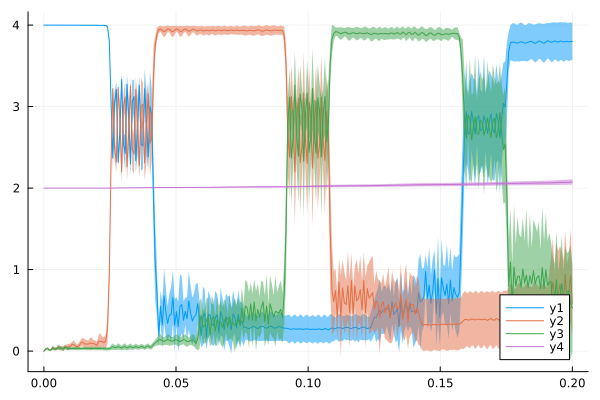

In [101]:
using DifferentialEquations.EnsembleAnalysis
mv = [timestep_meanvar(enssol, n) for n in 1:size(enssol, 1)];
v = stack(last.(mv))'
m = stack(first.(mv))'
plot(ts, m; ribbon = (sqrt.(v),sqrt.(v)))